# Imports and parameters

In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as cte
from astropy import constants
from PerseusGammaCalibration import perseus_model_library
import minot

# Modify plotting parameters
dict_base = {'font.size':        18,
             'legend.fontsize':  18,
             'xtick.labelsize':  18,
             'ytick.labelsize':  18,
             'axes.labelsize':   18,
             'axes.titlesize':   18,
             'figure.titlesize': 18,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

# Define the models

In [2]:
# Reference model
C0 = perseus_model_library.default_model()

# Taylor direct measurement + 2/3 scaling
C1 = perseus_model_library.set_magnetic_field_model(C0, case='Taylor2006')

# Walker KHI
C2 = perseus_model_library.set_magnetic_field_model(C0, case='Walker2017')

# Bonafede 2010 + Coma scaling best
C3 = perseus_model_library.set_magnetic_field_model(C0, case='Bonafede2010best')

# Bonafede 2010 + Coma scaling LL
C4 = perseus_model_library.set_magnetic_field_model(C0, case='Bonafede2010low')

# Bonafede 2010 + Coma scaling UL
C5 = perseus_model_library.set_magnetic_field_model(C0, case='Bonafede2010up')

# Bonafede 2010 + Coma scaling 2/3
C6 = perseus_model_library.set_magnetic_field_model(C0, case='Bonafede2010std')

# Comparison

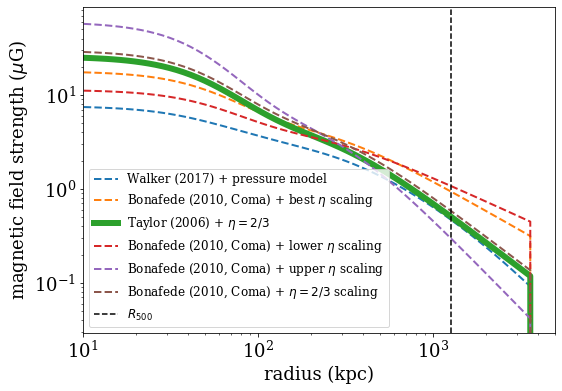

In [4]:
fig = plt.figure(0, figsize=(8, 6))
r, B = C2.get_magfield_profile()
plt.loglog(r,B, label=C2.name, linewidth=2, ls='--')
r, B = C3.get_magfield_profile()
plt.loglog(r,B, label=C3.name, linewidth=2, ls='--')
r, B = C1.get_magfield_profile()
plt.loglog(r,B, label=C1.name, linewidth=6)
r, B = C4.get_magfield_profile()
plt.loglog(r,B, label=C4.name, linewidth=2, ls='--')
r, B = C5.get_magfield_profile()
plt.loglog(r,B, label=C5.name, linewidth=2, ls='--')
r, B = C6.get_magfield_profile()
plt.loglog(r,B, label=C6.name, linewidth=2, ls='--')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$R_{500}$')
plt.xlabel('radius (kpc)')
plt.ylabel('magnetic field strength ($\\mu$G)')
plt.xlim(10,5000)
plt.legend(loc='lower left', fontsize=12)
plt.savefig(C0.output_dir+'/Magnetic_Field_Models.pdf')

/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encounter

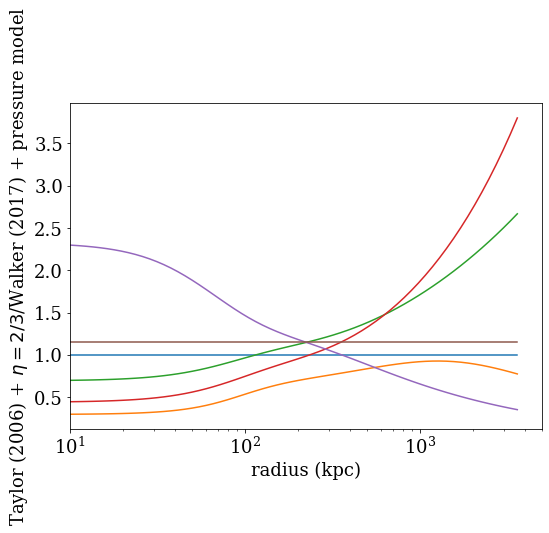

In [5]:
fig = plt.figure(0, figsize=(8, 6))
r1, B1 = C1.get_magfield_profile()
r2, B2 = C2.get_magfield_profile()
r3, B3 = C3.get_magfield_profile()
r4, B4 = C4.get_magfield_profile()
r5, B5 = C5.get_magfield_profile()
r6, B6 = C6.get_magfield_profile()
plt.plot(r1, B1/B1)
plt.plot(r1, B2/B1)
plt.plot(r1, B3/B1)
plt.plot(r1, B4/B1)
plt.plot(r1, B5/B1)
plt.plot(r1, B6/B1)
plt.xlabel('radius (kpc)')
plt.ylabel(C1.name+'/'+C2.name)
plt.xlim(10,5000)
plt.xscale('log')


# Compute beta plasma profile

/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/Project/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encounter

(1, 500)

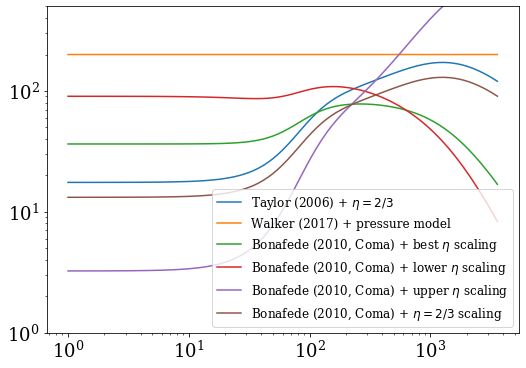

In [28]:
Y = C0.helium_mass_fraction
Z = C0.metallicity_sol*C0.abundance
mu_gas,mu_e,mu_p,mu_alpha = minot.ClusterTools.cluster_global.mean_molecular_weight(Y=Y, Z=Z)
#B = (2*const.mu0*(mu_e/mu_gas)*P/200)**0.5

r,p = C0.get_pressure_gas_profile()
p = p*mu_e/mu_gas
r1, B1 = C1.get_magfield_profile()
r2, B2 = C2.get_magfield_profile()
r3, B3 = C3.get_magfield_profile()
r4, B4 = C4.get_magfield_profile()
r5, B5 = C5.get_magfield_profile()
r6, B6 = C6.get_magfield_profile()
plt.loglog(r,p.to_value('keV cm-3')/(B1**2/(2*constants.mu0)).to('keV cm-3'), label=C1.name)
plt.loglog(r,p.to_value('keV cm-3')/(B2**2/(2*constants.mu0)).to('keV cm-3'), label=C2.name)
plt.loglog(r,p.to_value('keV cm-3')/(B3**2/(2*constants.mu0)).to('keV cm-3'), label=C3.name)
plt.loglog(r,p.to_value('keV cm-3')/(B4**2/(2*constants.mu0)).to('keV cm-3'), label=C4.name)
plt.loglog(r,p.to_value('keV cm-3')/(B5**2/(2*constants.mu0)).to('keV cm-3'), label=C5.name)
plt.loglog(r,p.to_value('keV cm-3')/(B6**2/(2*constants.mu0)).to('keV cm-3'), label=C6.name)
plt.legend(fontsize=12, loc='lower right')
plt.ylim(1,500)

# Compute how changing the magnetic field would change CTA results

In [5]:
# Pure hadronic parameter
C1 = perseus_model_library.set_pure_hadronic_model(C1, ('density', 0.78), 0.045, 2.36)
C1.name

'Taylor (2006) + $\\eta=2/3$'

In [6]:
Bfact = 10.0

In [7]:
Rmax = 100*u.kpc
f1,s1 = C1.get_synchrotron_spectrum(Rmax=Rmax)
e1,n1 = C1.get_cre2_spectrum(Rmax=Rmax)
r0 = C1.magfield_model['radius']
B0 = C1.magfield_model['profile']
C1.magfield_model = {'name':'User','radius':r0, 'profile':B0*Bfact}
f2,s2 = C1.get_synchrotron_spectrum(Rmax=Rmax)
e2,n2 = C1.get_cre2_spectrum(Rmax=Rmax)

Text(0.5, 0, 'Frequency (GHz)')

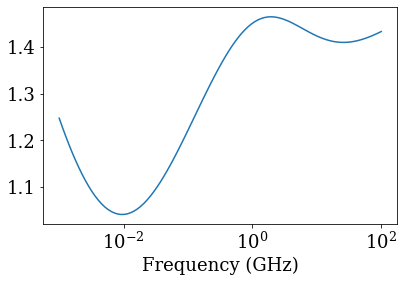

In [8]:
plt.plot(f1, s2/s1)
plt.xscale('log')
plt.xlabel('Frequency (GHz)')

Text(0.5, 0, 'Frequency (GHz)')

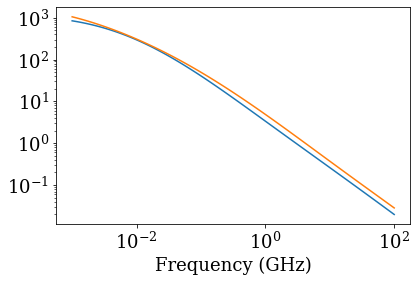

In [9]:
plt.loglog(f1, s1)
plt.loglog(f2, s2)
plt.xlabel('Frequency (GHz)')

Text(0.5, 0, 'Energy')

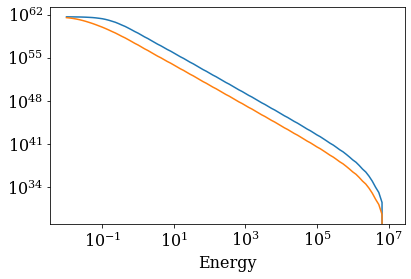

In [10]:
plt.loglog(e1, n1)
plt.loglog(e2, n2)
plt.xlabel('Energy')